In [45]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS
c:\Dev\MinorProject\WDSS


In [46]:
import torch

from config import Settings, device
from commons import initialize
from utils.image_utils import ImageUtils
from network.losses import ImageEvaluator

In [47]:
settings = Settings('config/config.json', 'TEST')
initialize(settings)

Job: pp_relu_inr_only, Model: TEST, Device: cuda
Model path: out\pp_relu_inr_only-TEST\model
Log path: out\pp_relu_inr_only-TEST\logs


In [48]:
from network.dataset import *
from utils.masks import Mask

test, val, test = WDSSDatasetCompressed.get_datasets(settings)

In [49]:
raw_frames = test._get_raw_frames(0)

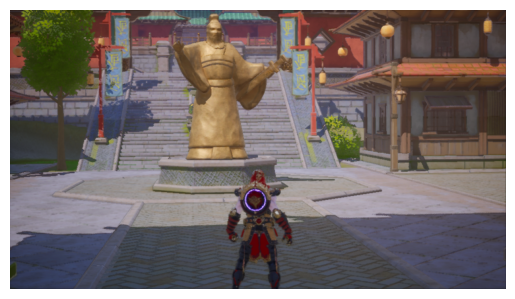

In [50]:
ImageUtils.display_image(raw_frames[RawFrameGroup.HR])

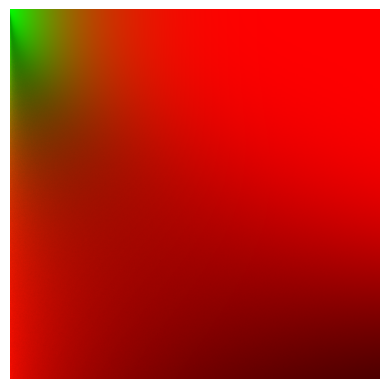

torch.Size([3, 512, 512])


In [51]:
# Load the BRDF pre-integration
precomputed_cv = ImageUtils.load_exr_image_opencv('data/Precomputed.exr')
precomp = ImageUtils.opencv_image_to_tensor(precomputed_cv).squeeze(0)

# Distribute the channel 1 to the other channels, discarding the other channels
precomp_white = precomp[0, :, :]
precomp_black = precomp[1, :, :]
ImageUtils.display_image(precomp)
print(precomp.shape)

In [52]:
def brdf_demodulate(
    frame: torch.Tensor,
    brdf_map: torch.Tensor
) -> torch.Tensor:
    """Demodulate the frame using the BRDF map.
    """
    brdf_map = brdf_map.clone()
    pos = (brdf_map <= 1e-6)
    brdf_map[pos] = 1.0
    demodulated_frame = frame / brdf_map
    demodulated_frame[pos] = frame[pos]
    brdf_map[pos] = 0.0

    return demodulated_frame

def brdf_remodulate(
    frame: torch.Tensor,
    brdf_map: torch.Tensor
) -> torch.Tensor:
    """Remodulate the frame using the BRDF map.
    """
    brdf_map = brdf_map.clone()
    pos = (brdf_map <= 1e-6)
    brdf_map[pos] = 1.0
    remodulated_frame = frame * brdf_map
    brdf_map[pos] = 0.0

    return remodulated_frame

In [53]:
def compute_brdf(
    diffuse: torch.Tensor,
    roughness: torch.Tensor,
    metallic: torch.Tensor,
    specular: torch.Tensor,
    NoV: torch.Tensor,
    precomp: torch.Tensor
) -> torch.Tensor:
    """Demodulate the frame using the BRDF parameters.
    """
    nov_idx = (NoV * 511.0).long().clamp(0, 511)
    roughness_idx = (roughness * 511.0).long().clamp(0, 511)

    # Sample the pre-conputed BRDF lookup table
    pre_integration = precomp[0][nov_idx, roughness_idx]
    pre_integration_b = precomp[1][nov_idx, roughness_idx]

    # Compute specular reflactange
    specular = specular.expand(3, -1, -1)
    metallic = metallic.expand(3, -1, -1)

    # Compute the specular reflectance
    specular_color = torch.lerp(0.08 * specular, diffuse, metallic)

    # Calculate the BRDF
    brdf = diffuse * (1 - metallic) + pre_integration * specular_color + pre_integration_b.expand(3, -1, -1)
    return brdf


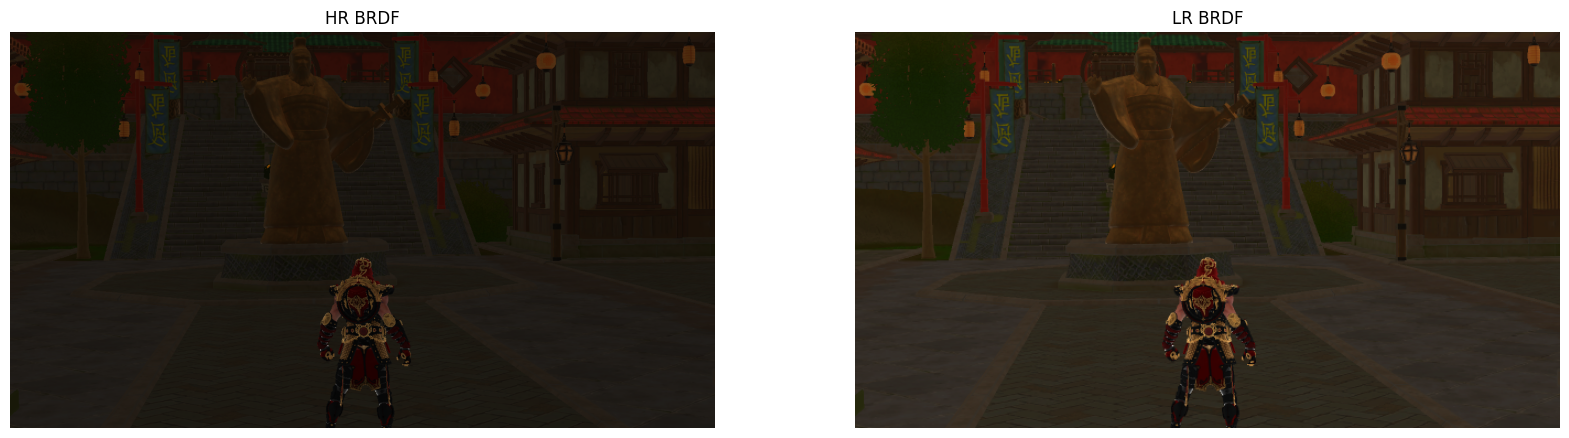

(tensor(0.0015), tensor(1.0944), tensor(0.0035), tensor(0.6654))

In [54]:
diffuse = raw_frames[RawFrameGroup.HR_GB][GB_Type.BASE_COLOR]
roughness = raw_frames[RawFrameGroup.HR_GB][GB_Type.ROUGHNESS]
metallic = raw_frames[RawFrameGroup.HR_GB][GB_Type.METALLIC]
specular = raw_frames[RawFrameGroup.HR_GB][GB_Type.SPECULAR]
NoV = raw_frames[RawFrameGroup.HR_GB][GB_Type.NoV]

brdf = compute_brdf(diffuse, roughness, metallic, specular, NoV, precomp)

diffuse_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.BASE_COLOR]
roughness_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.ROUGHNESS]
metallic_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.METALLIC]
specular_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.SPECULAR]
NoV_lr = raw_frames[RawFrameGroup.LR_GB][GB_Type.NoV]

# brdf_lr = compute_brdf(diffuse_lr, roughness_lr, metallic_lr, specular_lr, NoV_lr, precomp)
brdf_lr = ImageUtils.upsample(brdf.unsqueeze(0), 0.5).squeeze(0)

ImageUtils.display_images([brdf, brdf_lr], ['HR BRDF', 'LR BRDF'])

torch.min(brdf), torch.max(brdf), torch.min(brdf_lr), torch.max(brdf_lr)

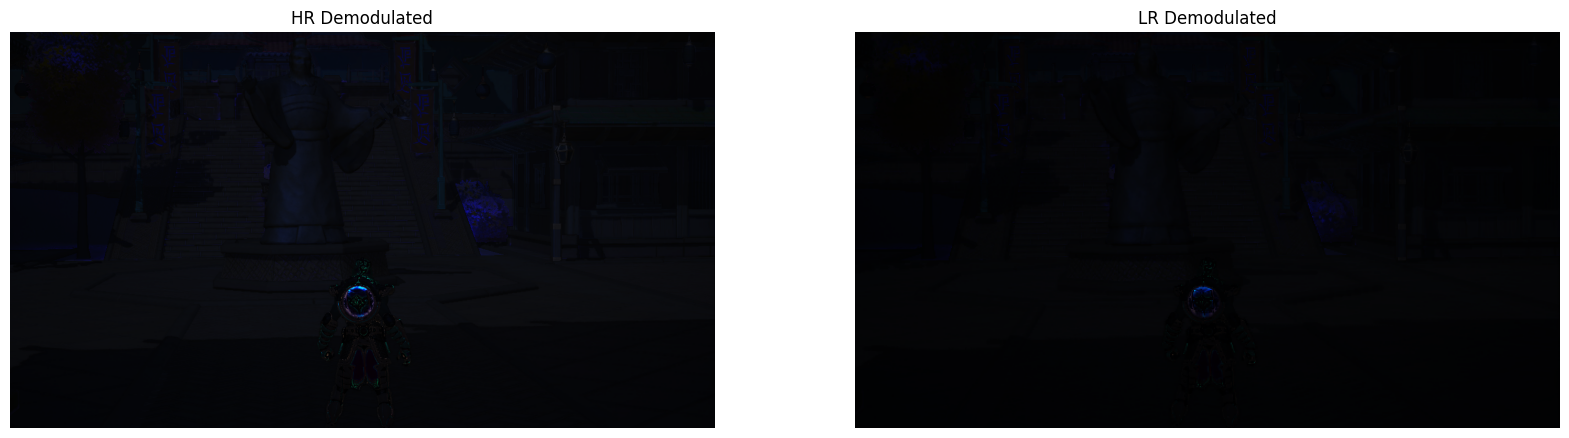

(tensor(0.), tensor(1.), tensor(0.), tensor(211.2951))

In [62]:
hr_frame = raw_frames[RawFrameGroup.HR] 
lr_frame = raw_frames[RawFrameGroup.LR]

demodulated_hr = brdf_demodulate(hr_frame, brdf)
demodulated_lr = brdf_demodulate(lr_frame, brdf_lr)

demodulated_hr = demodulated_hr.clamp(0, 100) / 100.0
ImageUtils.display_images([demodulated_hr, demodulated_lr], ['HR Demodulated', 'LR Demodulated'])
demodulated_hr.min(), demodulated_hr.max(), demodulated_lr.min(), demodulated_lr.max()

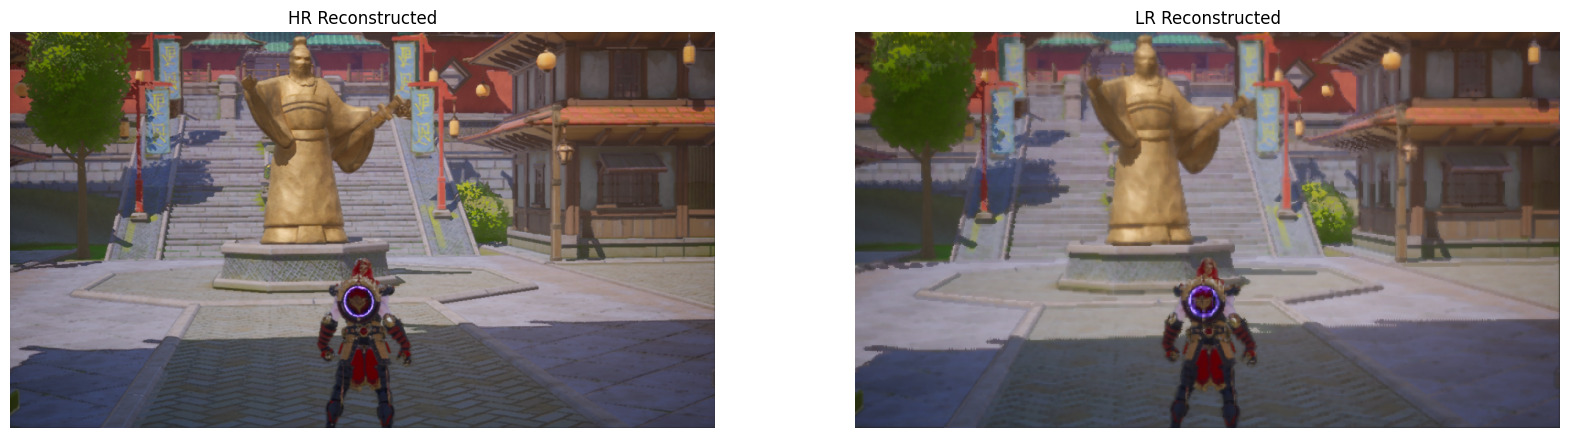

PSNR: 161.64996337890625, MSE: 6.839160406579465e-17


In [56]:
# Reconstruct the frame
reconstructed_hr = brdf_remodulate(demodulated_hr, brdf)
reconstructed_lr = brdf_remodulate(demodulated_lr, brdf_lr)

ImageUtils.display_images([reconstructed_hr, reconstructed_lr], ['HR Reconstructed', 'LR Reconstructed'])

# Compute and display the loss
psnr = ImageEvaluator.psnr(reconstructed_hr, hr_frame)
mse = ImageEvaluator.mse(reconstructed_hr, hr_frame)
print(f'PSNR: {psnr}, MSE: {mse}')

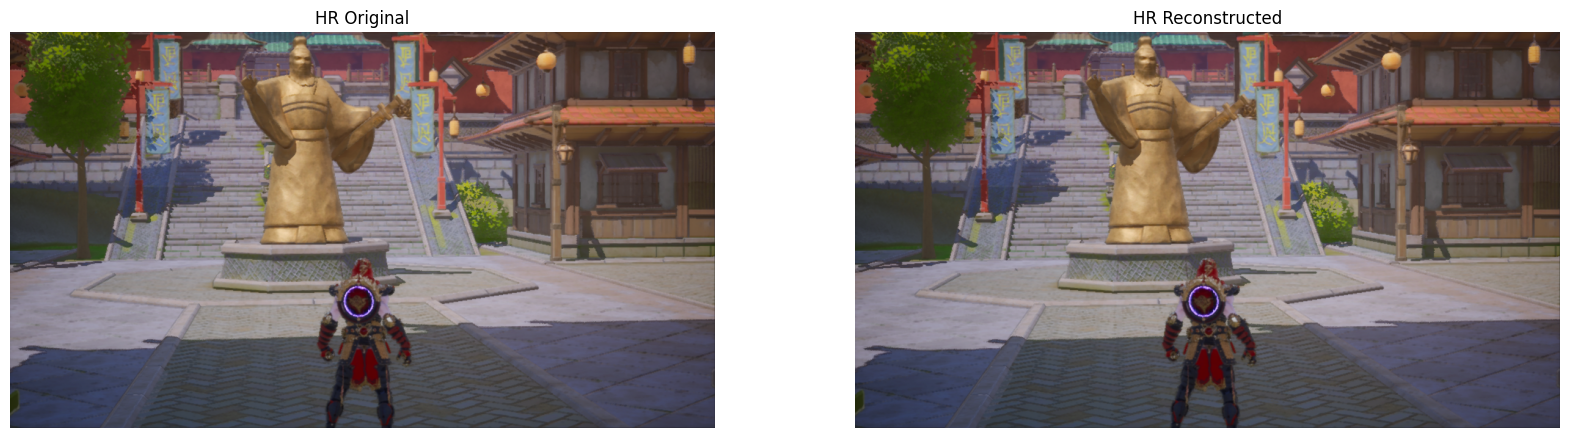

In [57]:
ImageUtils.display_images([hr_frame, reconstructed_hr], ['HR Original', 'HR Reconstructed'])

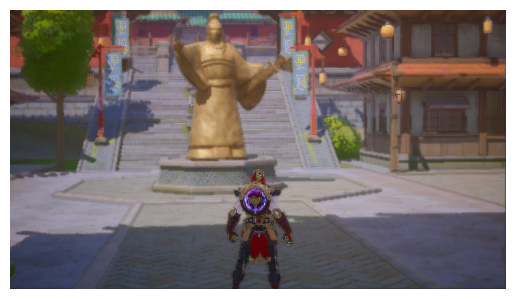

PSNR: 25.712900161743164, MSE: 0.0026835522148758173


In [58]:
# Upsample the demodulated lr frame and reconstruct it
upsampled_lr = ImageUtils.upsample(demodulated_lr.unsqueeze(0), 2, 'bilinear').squeeze(0)
reconstructed_upsampled_lr = brdf_remodulate(upsampled_lr, brdf).clamp(0, 1)

ImageUtils.display_image(reconstructed_upsampled_lr, normalize=False)

# Compute and display the loss
psnr = ImageEvaluator.psnr(reconstructed_upsampled_lr, hr_frame)
mse = ImageEvaluator.mse(reconstructed_upsampled_lr, hr_frame)
print(f'PSNR: {psnr}, MSE: {mse}')

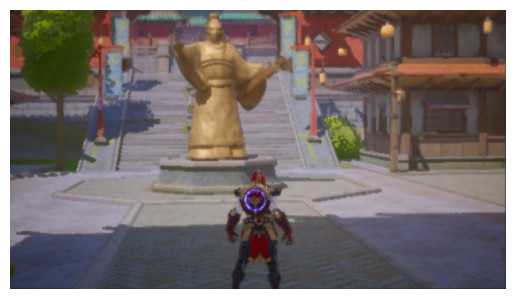

PSNR: 28.266624450683594, MSE: 0.0014905185671523213


In [59]:
# Just simply upsample the lr frame and compute the loss
upsampled_lr = ImageUtils.upsample(lr_frame.unsqueeze(0), 2, 'bilinear').squeeze(0)

# Compute and display the loss
psnr = ImageEvaluator.psnr(upsampled_lr, hr_frame)
mse = ImageEvaluator.mse(upsampled_lr, hr_frame)

ImageUtils.display_image(upsampled_lr, normalize=False)
print(f'PSNR: {psnr}, MSE: {mse}')